# 
# 
# Signal processing / System identification

## Stages with Inputs
### Signal processing (Consider two analyses in different frequency bands)
- ~~Filter and Decimation (IIR Filter)~~ (sample has been sampled already in the desired frequency band to keep uq less complex)
    - $M = $ ~~Number of IIR filter coefficients ("order")~~
    - $f_c =$ ~~Filter 3 dB cutoff frequency~~
    - $d = $ ~~Decimation rate (every d-th sample)~~
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (Default Hamming is chosen for Welch's estimator, besides PSDs are used only in pLSCF and there, usage of an exponential window is undisputed)
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use reference based OMA ($n_\mathrm{ref} = 2$ Number and $\operatorname{loc}_\mathrm{ref}=201x, 201y$ location of reference channels, always available in acquired signals) 

### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies

## Outputs
- Cross-validated reconstruction error of the identified system(s)
- Identified:
    - Natural frequencies
    - Damping ratios
    - Mode shapes

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext memory_profiler
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import vars_definition, stage2mapping,stage3mapping, stage2n3mapping

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

from model.acquisition import Acquire, sensor_position
from helpers import get_pcd

import pyOMA 

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef, plot_corr_synth,show_channel_reconstruction
# from pyOMA.core.PLSCF_old import PLSCF as PLSCF_old
from pyOMA.core.PLSCF import PLSCF, plot_spec_synth
from pyOMA.core.SSIData import SSIDataMC, SSIDataCV, plot_sig_synth
from pyOMA.core.PostProcessingTools import MergePoSER
from pyOMA.core.PlotMSH import ModeShapePlot
from pyOMA.core.StabilDiagram import StabilCalc, StabilPlot
from pyOMA.GUI.JupyterGUI import StabilGUIWeb, PlotMSHWeb
from pyOMA.core.PostProcessingTools import pair_modes, compare_modes



import logging


%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas

## Parameters

In [2]:
result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

## Signal Processing


In [3]:
jid = '9537b650_883ca5e6'

# jid = '0e8132ee_0e61d227'
seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

    
# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / 'samples' / id_ale
    this_result_dir = this_result_dir / id_epi
    
    seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
    
acqui_c = Acquire.load(this_result_dir / 'measurement.npz', differential='sampled')
# acqui_c = Acquire.load(this_result_dir / 'measurement.npz', differential='nosigs')
pd_kwargs = acqui_c.to_prep_data()
ref_channels=np.where(acqui_c.channel_defs[:,0]==201)[0]


'''
those were the "manipulated" / manually set parameters for this sample

n_locations = 5
DTC = 1.6
sensitivity_nominal = 1.02
sensitivity_deviation_percent = 5.
spectral_noise_slope = -0.5
sensor_noise_rms = 0.006
range_estimation_duration = 300
range_estimation_margin = 3.
DAQ_noise_rms = 0.06
decimation_factor = 7
anti_aliasing_cutoff_factor = 0.4
quant_bit_factor = 4
duration = 62.*60
jid = '0e8132ee_0e9f1c84'
'''
acqui_c.modal_frequencies_samp

INFO:model.acquisition:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/9537b650/883ca5e6/measurement.npz


array([0.15696927, 0.16334913, 0.17907124, 0.17973269, 0.31541637,
       0.3352036 , 0.5801349 , 0.60380538, 1.19951563, 1.24947417,
       2.01113829, 2.09744073, 3.03492802, 3.16726108, 4.28537709,
       4.47227938, 5.75791507, 6.00769035, 7.44085185, 7.76186574,
       9.32672176, 9.72715719])

In [300]:
channel_defs = acqui_c.channel_defs, 
channel_headers = pd_kwargs['channel_headers']

coordinates = np.copy(channel_defs[0])
coordinates[:,1:3] = 0
coordinates = np.roll(coordinates, -1, axis=1)

nodes = {str(coordinates[i*2,2]):list(coordinates[i*2,:]) for i in range(len(channel_headers)//2)}
lines = [([coordinates[i*2,2], coordinates[i*2+2, 2]]) for i in range(len(channel_headers)//2 - 1)]

chan_dofs = []
for i in range(len(channel_defs[0])):
    channel_name = channel_headers[i]
    node = str(coordinates[i,2])
    az, elev = [(0, 0), (270, 0), (90, 0)][channel_defs[0][i,1]]
    chan_dofs.append([i, node, az, elev, channel_name])
    
geometry = GeometryProcessor(nodes, lines)

In [301]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)

INFO:pyOMA.core.PreProcessingTools:Estimating PSD by Welch's method with 1022 frequency lines, 50 non-overlapping segments and a hamming window...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Function by Welch's method with 512 time lags and 50 non-overlapping segments.
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=512 and num_blocks=50...
....................................................................................................


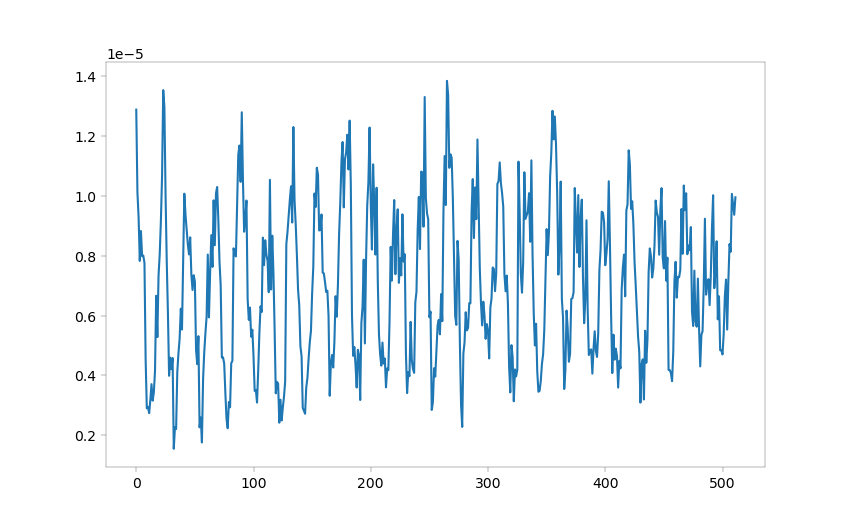

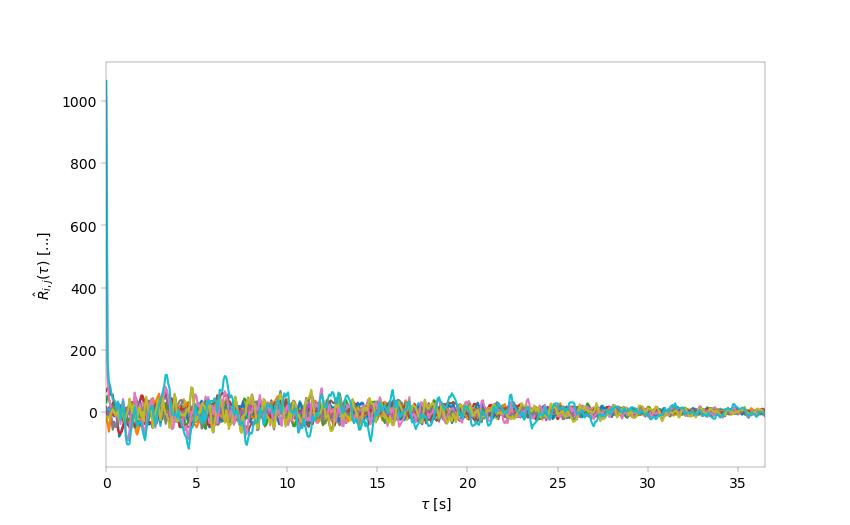

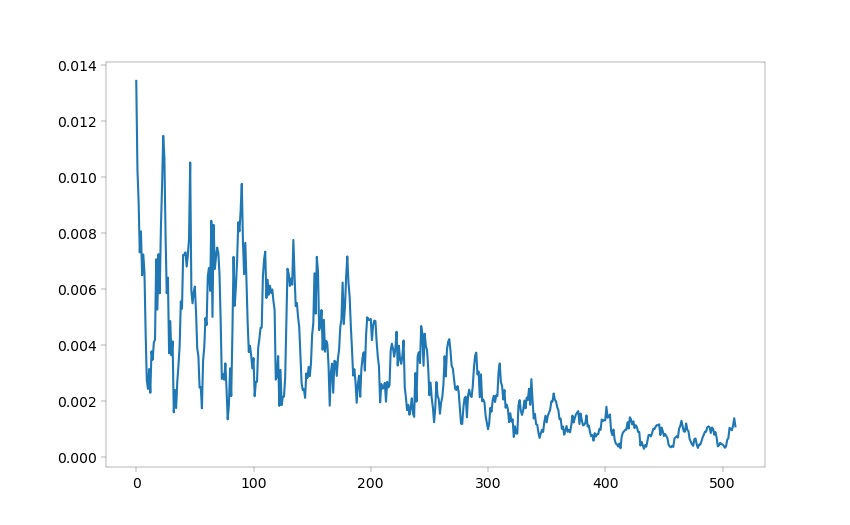

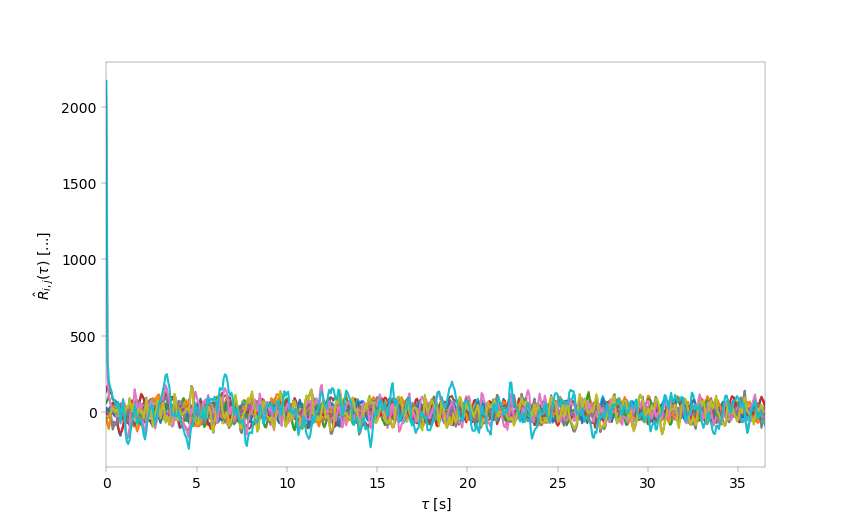

In [210]:
'''
For FFT n_lines must be N_segment
but N_segment = N / n_segments and n_lines = (m_lags - 1) * 2 is a free parameter


rework corr_welch to take n_segments as parameter
    - if n_segments not given, compute it from m_lags
    - pass n_segments to psd_welch and n_lines=None
    - cut off resulting correlation sequence
    
rework psd_welch logic to take n_lines=None without errors
    - test equivalence with previous behavior

compare corr_welch and corr_bt for approximate match
    
'''


sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals)
# prep_signals.n_lines_wl = None
# prep_signals.m_lags_wl = None
prep_signals.corr_welch(m_lags=512, n_segments=50)
sp.plot_correlation()
plt.figure()
plt.plot(prep_signals.var_corr_wl[-1,-1,:])

prep_signals.corr_blackman_tukey(m_lags=512, num_blocks=50)
sp.plot_correlation()
plt.figure()
plt.plot(prep_signals.var_corr_bt[-1,-1,:])


plt.show()

### decimation

- prior to decimation, the signal has been 
  - largely oversampled [35,70] Hz, (with the intent to reduce sampling noise)
  - mdoerately oversampled [10, 35] Hz, (to account for incomplete knowledge of actual natural frequncies)
  - sampled at the final bandwidth [4, 10] Hz (naive approach)
- the analyst might want to downsample to the desired bandwidth, 
- the analyst has some knowledge from the provided numerical study (with uncertainties) 
  - that the highest natural frequency to identify will be at around 4 Hz (up to fifth-oder modes), 
  - but might also decide modes only up to the third order might be of interest (2 Hz)
- the analyst might be more or less knowledgeable and
  - run the analysis, using the signal as-is (naive approach)
  - downsample moderately (nyquist at twice the highest natural frequency of interest) (conservative approach)
  - downsample agressively (nyquist just above the highest natural frequency of interest) (high-risk approach)
- cutoff frequency / decimation factor must be translated into a meaningful parameter for uq
- final sampling frequency depends on the smaller value of this and the present nyquist rate
- these dependent parameters cannot be used directly for uq
- possible solutions: 
  - define approaches to OMA as parameter sets and do uq over these discrete sets (no optimization possible)
  - actually sampling and downsampling belong together, the choice is to either:
    - oversample and use-as-is out of missing experience (inexperienced)
    - oversample first and then downsample (conservative)
    - sample at the final bandwidth from the beginning (naive)
- **decision**
  - **do'nt do any further decimation here**  

In [6]:
# M = 4
# fc = 1
# d = 2
# prep_signals.decimate_signals(d, nyq_rat = prep_signals.sampling_rate / fc, order=M)

In [259]:
m_lags = 256
n_blocks = 30
prep_signals.corr_matrix_bt = None
prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=256 and num_blocks=30...
....................................................................................................


In [ ]:
sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals)
sp.plot_signals(timescale='time', psd_scale='db',per_channel_axes=True)

## System Identification

In [24]:
order=60
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(prep_signals.m_lags // 2)
modal_data.compute_state_matrices(order)

Assembling toeplitz matrix using pre-computed correlation functions 128 block-columns and 129 block rows
Computing state matrices with pinv-based method, with maximum model order 60...


## Reconstruction Error method

The reconstruction error of any system identification method is estimated by a $k$-fold cross validation method \cite{arlot...}. A part of the signal is used for system identification, and the system output is validated against the remaining part. System input and output must not necessarily be timestep signals, but can also be correlation functions, spectral densities, or other derived quantities depending on the employed identification method. In the following the method is given for the covariance-driven Stochastic Subspace Identification method.

The measured signal is divided into $n_{blocks}$ blocks for all channels. The correlation function of the signal from two channels $f$ and $g$ is then computed for each of these blocks using the Blackman-Tukey operator $$\hat{R}_{fg}[m] = \frac{1}{N_{block} - m}\sum_{n=0}^{N_{block} - m - 1} f[n] g[n + m] \; \text{,}$$ where $N_{block}$ is the blocklength in timesteps, and $m$ is the lag step of the correlation function. To avoid large confidence intervals of the correlation function for short blocklengths $N_{block}$ and high lags $m$, the second input signal $g[n+m]$ is allowed to overlap into the consecutive block by $m$ timesteps. The average $\hat{R}_{fg}[m]$ over $(k - 1) \lfloor \frac{n_{blocks}}{k}\rfloor $ randomly selected   blocks is used as input for system identification [^1]. The remainig $\lfloor \frac{n_{blocks}}{k}\rfloor $  are used for system validation. 

Given an identified stochstic state-space model in modally decoupled form $$\mathbf{x}_{j}[k+1] = \mathbf{\Lambda}_d \mathbf{x}_{j}[k] + \mathbf{w}_{j}[k]$$ $$ \mathbf{y}[k] = \mathbf{\Phi}x_{j}[k] + \mathbf{v}_{j}[k] \, \text{,}$$ where $j$ is the mode number,  \cite{reynders2012...} have demonstrated the synthetizaton of correlation functions.
$$ \mathbf{\tilde{R}}^\mathfrak{m}_{fg}[m] = \sum_{j=1}^{n_\mathfrak{m}} \lambda_{j}^{m-1}\mathbf{\phi}_{j}\mathbf{g}_{j}^T$$ and the modal participation vector $\mathbf{g}^\mathfrak{m}_{j}$ is the $j^\mathrm{th}$ column of the modally decomposed next-state output covariance matrix $\mathbf{G}^\mathrm{ref} = \mathbf{\Psi} \mathbf{G}^\mathfrak{m}$.
    
[^1]$\frac{1}{n_{blocks}} \sum_{i=1}^{n_{blocks}} \hat{R}_{fg,i}[m] = \hat{R}_{fg,i}[m]$

### Example synthetization

In [68]:
# Warning! Computationally expensive, but needed for nice, smooth spectra :-)
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)

m_lags = 2048
n_blocks = 1
prep_signals.corr_matrix_bt = None
# prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
prep_signals.corr_welch(m_lags, n_segments=n_blocks, refs_only=True)
pass

INFO:pyOMA.core.PreProcessingTools:Estimating PSD by Welch's method with 4094 frequency lines, 1 non-overlapping segments and a hamming window...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Function by Welch's method with 2048 time lags and 1 non-overlapping segments.
....................................................................................................


In [70]:
prep_signals.sampling_rate

5.384615384615385

DEBUG:pyOMA.core.PreProcessingTools:Arguments psd: n_lines=None, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning PSD by Welch's method with 4094 frequency lines, 1 non-overlapping segments and a hamming window...
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: n_lags=2048, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 5 non-overlapping segments.
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: n_lags=2048, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 5 non-overlapping segments.
DEBUG:pyOMA.core.PreProcessingTools:Arguments psd: n_lines=4094, method=None, {'refs_only': True}
DEBUG:pyOMA.core.PreProcessingTools:Returning PSD by Welch's method with 4094 frequency lines, 5 non-overlapping segments and a hamming window...
DEBUG:pyOMA.core.PreProcessi

(array([<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,

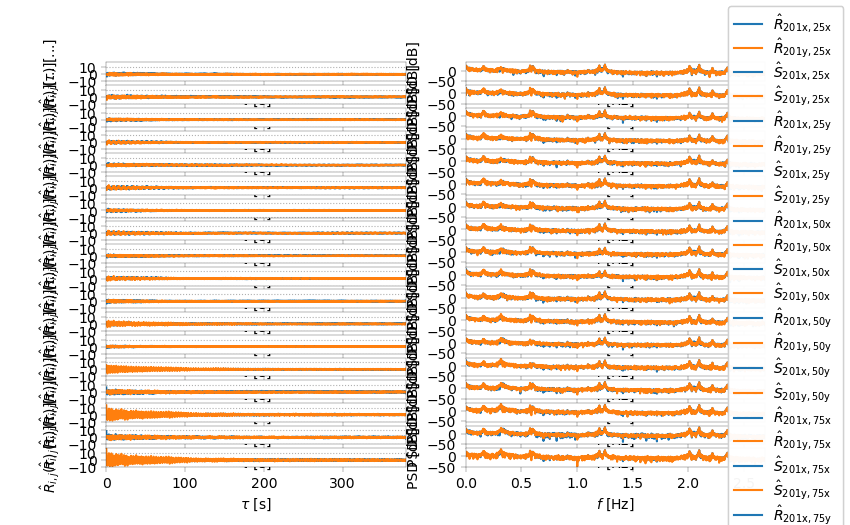

In [69]:
logger= logging.getLogger('pyOMA.core.PreProcessingTools')
logger.setLevel(level=logging.DEBUG)
sp = pyOMA.core.PreProcessingTools.SignalPlot(prep_signals)
sp.plot_signals(timescale='lags', psd_scale='db',per_channel_axes=True)
# logger.setLevel(level=logging.INFO)

#### SSICovRef

In [71]:
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(prep_signals.m_lags // 2)

order=28
A, C, G = modal_data.estimate_state(order)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
_, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)

INFO:pyOMA.core.SSICovRef:Assembling Toeplitz matrix using pre-computed correlation functions 1024 block-columns and 1025 block rows
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: n_lags=2048, method=blackman-tukey, {}
DEBUG:pyOMA.core.PreProcessingTools:Not returning because: self.corr_matrix_bt not available
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=2048 and num_blocks=1...
....................................................................................................
INFO:pyOMA.core.SSICovRef:Decomposing Toeplitz matrix


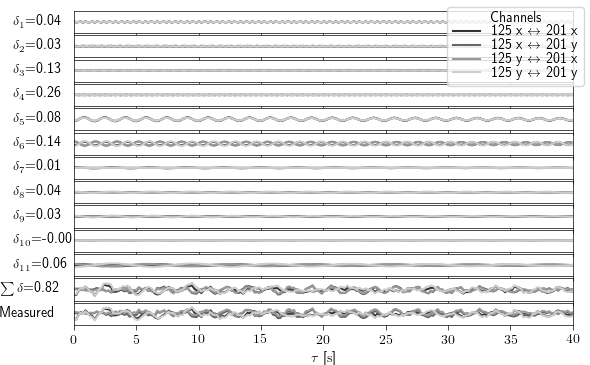

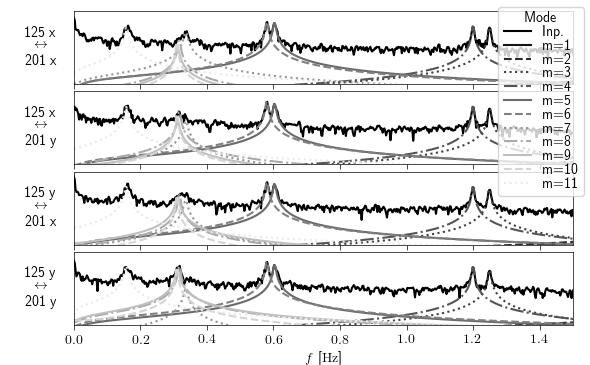

In [72]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    fig1, fig2 = plot_corr_synth(modal_data,
                                 modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                                 # modelist=[2,3,4,5,7,8,9,10],
                                 # modelist=[10,11,12,13,14,15,16], 
                                 # modelist=[0, 1, 2, 3, 4, 5], 
                                 # modelist=[6, 7, 8, 9,10,11], 
                                 channel_inds=[8,9], ref_channel_inds=[0,1])
    fig1.axes[0].set_ylim((-.003,.003))
    fig1.axes[0].set_xlim((0, 40))
    
    fig2.axes[1].set_xlim((0, 1.5))
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.png')
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/correlation_synthetization.pdf')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.png')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization.pdf')

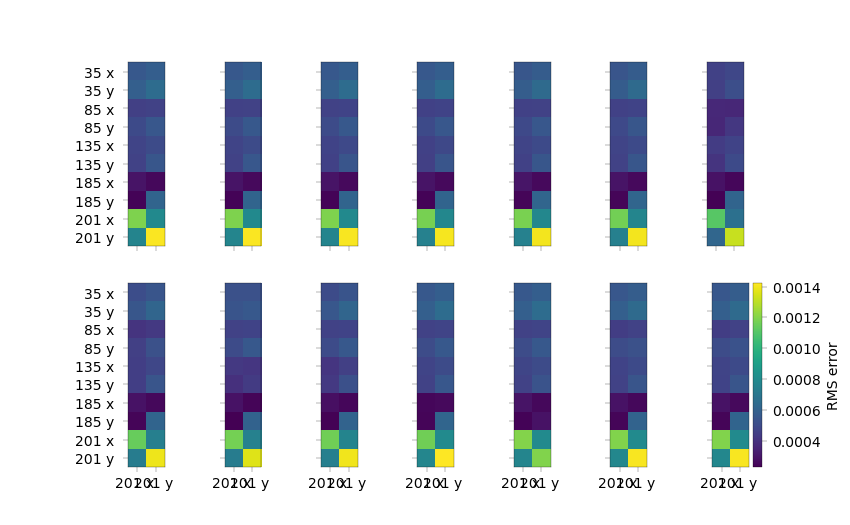

In [348]:
# prep_signals.corr_matrix[-1,-1,:]=0
show_channel_reconstruction(modal_data)

#### pLSCF

In [25]:
modal_data = PLSCF(prep_signals)
modal_data.build_half_spectra()

INFO:pyOMA.core.PLSCF:Constructing half-spectrum matrix ... 
DEBUG:pyOMA.core.PreProcessingTools:Arguments correlation: n_lags=2048, method=None, {}
DEBUG:pyOMA.core.PreProcessingTools:Returning Correlation Function by Welch's method with 2048 time lags and 12 non-overlapping segments.


In [26]:
alpha, beta_l_i = modal_data.estimate_model(35, False)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_residuals(alpha, beta_l_i)
# this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_state_space(alpha, beta_l_i)

half_spec_modal, modal_contributions = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=True)
# half_spec_rmfd = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=False)

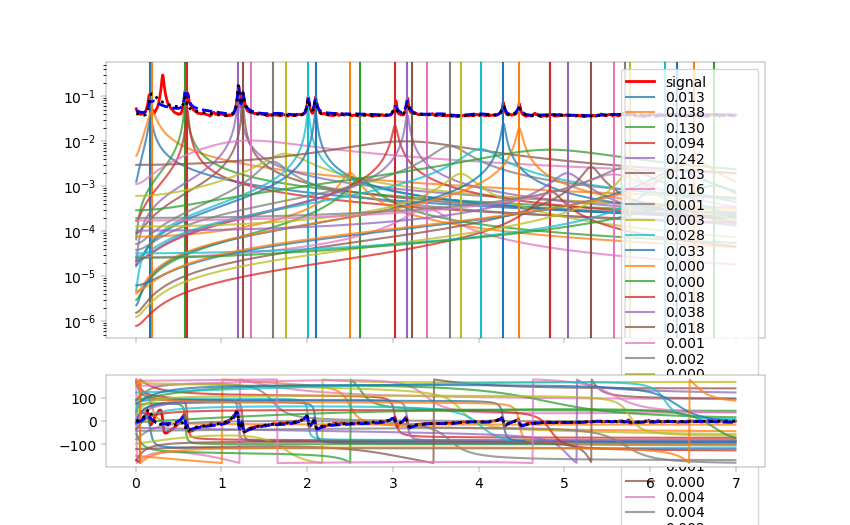

In [40]:
if True:
    num_modes = half_spec_modal.shape[-1]
    channel = 9
    ref_index = 1

    fig1,[ax1,ax2]=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(modal_data.pos_half_spectra[channel,ref_index,:]) , color='red', lw=2, label='signal') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(modal_data.pos_half_spectra[channel,ref_index,:], deg=True) , color='red', lw=2) 
    ax1.set_yscale('log')
    ylims = ax1.get_ylim()
    for mode in range(num_modes):
        line = ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(half_spec_modal[channel,ref_index,:,mode]), alpha=0.75, label=f'{np.abs(modal_contributions[mode]):1.3f}')
        ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(half_spec_modal[channel,ref_index,:,mode], deg=True), alpha=0.75) 
        ax1.axvline(this_modal_frequencies[mode], color=line[0].get_color())
    
    half_spec_synth = np.sum(half_spec_modal, axis=-1)
    half_spec_synth[:,:,:] += modal_data._lower_residuals[:,:,np.newaxis]
    half_spec_synth[:,:,:] += modal_data._upper_residuals[:,:,np.newaxis]*modal_data.selected_omega_vector[np.newaxis,np.newaxis,:]**2
    
    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(half_spec_synth[channel,ref_index,:]) , color='blue', lw=2, ls='dashed', label=f'modal {np.abs(np.sum(modal_contributions)):1.3f}') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(half_spec_synth[channel,ref_index,:], deg=True) , color='blue', lw=2, ls='dashed') 
    modal_data.synthesize_spectrum(alpha, beta_l_i, modal=False)
    ax1.plot(modal_data.selected_omega_vector/2/np.pi, np.abs(modal_data._half_spec_synth[channel,ref_index,:]) , color='black', lw=2, ls='dotted', label='model') 
    ax2.plot(modal_data.selected_omega_vector/2/np.pi, np.angle(modal_data._half_spec_synth[channel,ref_index,:], deg=True) , color='black', lw=2, ls='dotted') 

    # ax1.set_ylim(ylims)
    # ax1.set_xlim((0,1.5))
    ax1.legend()

In [26]:
np.abs(np.sum(modal_contributions))

0.7246477717691745

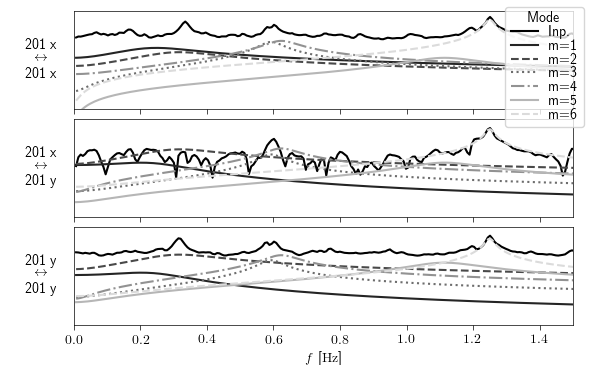

In [27]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")
from helpers import get_pcd
with matplotlib.rc_context(get_pcd('print')):  
    fig = plot_spec_synth(modal_data,
                    modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                    channel_inds=[8,9], ref_channel_inds=[0,1])

    fig.axes[1].set_xlim((0, 1.5))
    
    # fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization_plscf.png')
    # fig.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/spectrum_synthetization_plscf.pdf')

#### SSIData

In [18]:
modal_data = SSIDataCV(prep_signals)
num_training_blocks = 1
modal_data.build_block_hankel(prep_signals.m_lags // 2, num_blocks=n_blocks, training_blocks=np.random.choice(np.arange(n_blocks),num_training_blocks, False))

INFO:pyOMA.core.SSIData:Building Block-Hankel matrix from  1 out of 1 signal blocks with 1024 block-columns and 1024 block rows.
....................................................................................................
INFO:pyOMA.core.SSIData:Estimating subspace matrix...


In [19]:
A,C,Q,R,S = modal_data.estimate_state(30)
validation_blocks = np.arange(n_blocks)
# validation_blocks = np.array([4,5,6])
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
all_sig_synth, modal_contributions = modal_data.synthesize_signals( A, C, Q, R, S, validation_blocks)


In [167]:
if False:
    n_validation_blocks = validation_blocks.shape[0]
    num_blocks = modal_data.num_blocks
    total_time_steps = prep_signals.total_time_steps
    q = modal_data.num_block_rows
    p = modal_data.num_block_rows
    N_b = int(np.floor((total_time_steps - q - p) / num_blocks))
    N = N_b * num_blocks
    N_0_offset = total_time_steps - q - p - N
    N_offset = N_b // 15
    block_starts = validation_blocks*N_b + N_0_offset + p + q
    block_starts + N_b + q + p

    channel = 8

    plt.figure()
    t = prep_signals.t
    plt.plot(t, sig[:, channel], c='grey')
    ax = plt.gca()
    fig,axes = plt.subplots(5,2, sharex=True)
    axes = axes.flat
    for i in range(n_validation_blocks):
        sig_synth = all_sig_synth[i]

        ax.plot(t[block_starts[i]:block_starts[i]+N_b],np.sum(sig_synth[channel,:,:] ,axis=-1), alpha=0.5)

        for mode in range(10):

            axes[mode].plot(t[block_starts[i]:block_starts[i]+N_b],sig_synth[channel,:,mode], alpha=0.5)

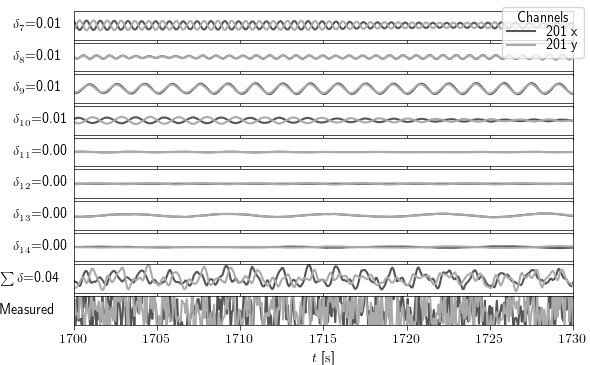

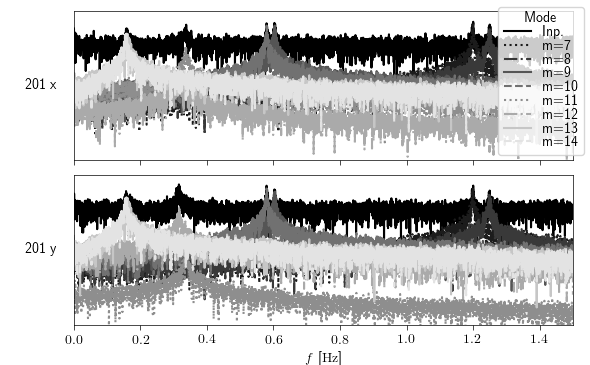

In [20]:
matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")

with matplotlib.rc_context(get_pcd('print')):  
    fig1, fig2 = plot_sig_synth(modal_data,
                        modelist = np.where((this_modal_frequencies<1.5) & (this_modal_frequencies>0.0))[0],
                        channel_inds=[8,9],i_block=0)
    fig1.get_axes()[0].set_xlim((1700,1730))
    fig1.get_axes()[0].set_ylim((-0.2,0.2))
    fig2.get_axes()[0].set_xlim((0,1.5))
    fig2.get_axes()[0].set_ylim(ymin=-40)
    fig2.subplots_adjust(left=None, bottom=None, right=0.97, top=0.97, wspace=None, hspace=0.1,)
    fig1.subplots_adjust(left=None, bottom=None, right=0.97, top=0.97, wspace=None, hspace=0.1,)
    
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization.png')
    # fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization.pdf')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization_spectrum.png')
    # fig2.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/signal_synthetization_spectrum.pdf')

### Example: Reconstruction Error

The model error with a given parameter set (m_lags, model_order) is sought for by separating the input data into a number of blocks. The sum of modal reconstruction errors is computed on each block model and averaged. This measure can be used to judge on the suitability of the chosen parameter set. However, it is suspectible to overfit. 

How do we penalize overfit?
Overfitted models generally produce almost perfect reconstruction, but achieve that at the cost of many (noise) modes, splitted modes, etc. The number of modes increases, i.e. the "number of directions in the parameter space that are unimportant for prediction" are large. A trade-off between model order and prediction has to be made. This is easily visible in a full-factorial setting or can be found by optimization, but it is not suitable as a UQ criterion, because overfit models would generally perform best.

Wen want the prediction be concentrated to as few modes as possible, i.e. the mean value should be largest? No, because this gives best results at lowest orders.

Additional problem, when modesplitting occurs, one member of the pair may have very high modal contributions, while the other member compensates this with a negative contribution

Its  not known beforehand, how much of the signal can be reconstructed. The question is, how many modes do we need to construct as much of the physical signal (not the noise content) as possible?  An approach would be to segment the sequence of modal contributions of a single model into the modes with high MC and the noise modes. A first approach was to find local minima in estimated kernel densities as the segmentation points. This frequently rejects too many modes (all). A second approach was to find the largest gap in modal contributions (argmax of differences of sorted mcs). That also does not lead to satisfactory results. We seem to have reached a dead-end, where others have failed before and why OMA is generally hard to automate.

We also cannot reject a fixed or a relative number of modes, because we do not know how many physical modes are observable in the signal. Because, ideally, if there is no noise and the right model order is chosen, all modes contribute to the physical signal.


Show a full-factorial example over a range of m_lags and model_orders. Additionally perform a convergence study over the number of blocks.

In [6]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
prep_signals.add_chan_dofs(chan_dofs)


INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=100 and num_blocks=1...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=1...
....................................................................................................
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=300 and num_blocks=1...
....................................................................................................


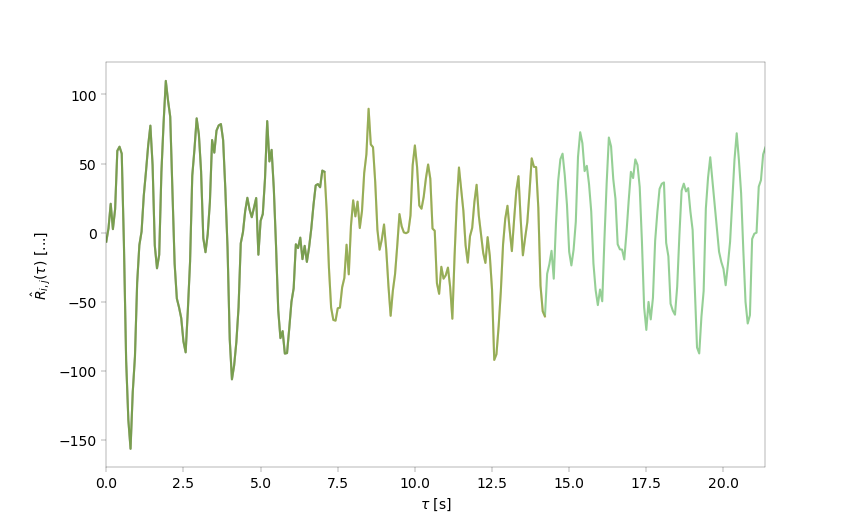

In [7]:
plt.figure()
ax = plt.subplot()
for m_lags in [100,200,300]:
    prep_signals.corr_blackman_tukey(m_lags, refs_only=True)
    pyOMA.core.PreProcessingTools.SignalPlot(prep_signals).plot_correlation(channels=[0], refs=[8], ax=ax, plot_kwarg_dict={'alpha':0.5})
    

In [108]:
n_blocks = 40

k = 10


max_model_order = 40
max_m_lags = 200
n_orders = 37
n_m_lags = 37

orders = np.linspace(max_model_order/10,max_model_order,n_orders, dtype=int)
all_lags = np.linspace(max_m_lags/10,max_m_lags,n_m_lags, dtype=int)

prep_signals.corr_blackman_tukey(max_m_lags, num_blocks=n_blocks, refs_only=True)
pass

ValueError: The segment length 96 must not be shorther than the number of lags 200

In [111]:
rng = np.random.default_rng(seed)

cardinality = n_blocks // k
block_indices = np.arange(cardinality*k)
rng.shuffle(block_indices)
block_indices, cardinality


(array([38, 24, 10,  6,  2, 36,  1,  9, 15, 14, 34, 17, 28, 16, 39, 27,  4,
        20,  8, 35, 23, 26, 18, 11, 19,  7, 37, 29,  3, 32, 30, 13, 31, 33,
        25,  0, 21, 22,  5, 12]),
 4)

In [121]:
i=9
test_set = block_indices[i * cardinality:(i + 1) * cardinality]
training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')
display(test_set, training_set)

array([21, 22,  5, 12])

array([38, 24, 10,  6,  2, 36,  1,  9, 15, 14, 34, 17, 28, 16, 39, 27,  4,
       20,  8, 35, 23, 26, 18, 11, 19,  7, 37, 29,  3, 32, 30, 13, 31, 33,
       25,  0])

In [ ]:
meth_ind = 2
method = ['ssicovref', 'plscf', 'ssidata' ][meth_ind]
res_fname = result_dir / ['example_reconstruction_validation.npy', 'example_reconstruction_validation_plscf.npy', 'example_reconstruction_validation_ssidata.npy'][meth_ind]

if os.path.exists(res_fname) and True:
    all_modal_contributions = np.load(res_fname)
else:
    if meth_ind == 0:
        modal_data = BRSSICovRef(prep_signals)
    elif meth_ind == 1:
        modal_data = PLSCF(prep_signals)
    elif meth_ind == 2:
        modal_data = SSIDataCV(prep_signals)
    
    model_performance = np.zeros((n_m_lags, n_orders))
    performance_deviation = np.zeros((n_m_lags, n_orders))
    all_modal_contributions = np.full((n_m_lags, n_orders, k, max_model_order), np.nan)

    for i_m_lags in range(n_m_lags):
        this_m_lags = all_lags[i_m_lags]
        print(this_m_lags//2)
        for i in range(k):

            test_set = block_indices[i * cardinality:(i + 1) * cardinality]
            training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')
            
            if meth_ind != 2:
                prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[training_set,...,:this_m_lags], axis=0)
                prep_signals.n_lines_bt = (this_m_lags - 1) * 2
            
            if meth_ind == 0:
                modal_data.build_toeplitz_cov(int(this_m_lags // 2))
            elif meth_ind == 1:
                modal_data.build_half_spectra(int(this_m_lags),-1,100)
            elif meth_ind == 2:
                modal_data.build_block_hankel(num_block_rows=int(this_m_lags) // 2, num_blocks=n_blocks, training_blocks=training_set)
            
            if meth_ind != 2:
                prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[test_set,...,:this_m_lags], axis=0)
            
            for i_order in range(n_orders):
                order = orders[i_order]
                
                if modal_data.max_model_order is not None and order>modal_data.max_model_order: continue
                
                if meth_ind == 0:
                    A, C, G = modal_data.estimate_state(order)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
                    _, this_modal_contributions = modal_data.synthesize_correlation(A, C, G)
                elif meth_ind == 1:
                    alpha, beta_l_i = modal_data.estimate_model(order, False)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis_residuals(alpha, beta_l_i)
                    _, this_modal_contributions = modal_data.synthesize_spectrum(alpha, beta_l_i, modal=True)
                if meth_ind == 2:
                    A,C,Q,R,S = modal_data.estimate_state(order)
                    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, = modal_data.modal_analysis(A, C)
                    _, this_modal_contributions = modal_data.synthesize_signals( A, C, Q, R, S, test_set)
                    
                # _, _, _, _, this_modal_contributions = modal_data.single_order_modal(order, synth_corr=True)
                nonzero = this_modal_contributions != 0
                all_modal_contributions[i_m_lags,i_order, i, :np.sum(nonzero)] = this_modal_contributions[nonzero]
    
    np.save(res_fname, all_modal_contributions)
    
    logger.setLevel(level=logging.INFO)


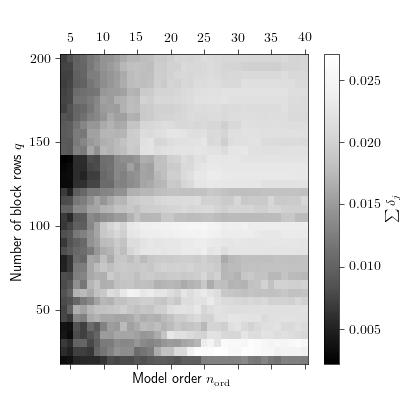

In [16]:
all_modal_contributions2 = np.copy(all_modal_contributions)

#reject noise modes but keep out-of-phase split mode (=negative mc) to counteract high mc of corresponding in-phase mode

if False:
    for i_m_lags in range(n_m_lags):
        for i_order in range(n_orders):

            this_modal_contributions = all_modal_contributions2[i_m_lags, i_order,:,:]
            this_modal_contributions = this_modal_contributions[~np.isnan(this_modal_contributions)]
            this_modal_contributions = np.abs(np.sort(this_modal_contributions))

            if this_modal_contributions.shape[0]<2:continue
            argmax = np.argmax(np.diff(this_modal_contributions))
            thresh = this_modal_contributions[argmax]
            
            this_modal_contributions = all_modal_contributions2[i_m_lags, i_order,:,:]
            indexer = this_modal_contributions**2 <= thresh**2
            all_modal_contributions2[i_m_lags, i_order,  indexer] = np.nan
else:        
    all_negative_contributions = np.copy(all_modal_contributions2)
    all_negative_contributions[all_negative_contributions>=0.0] = np.nan
    all_modal_contributions2[all_modal_contributions2 <=0.0] = np.nan
    pass

#sum over modes, mean over validation sets
model_performance2 = np.nanmean(np.nansum(all_modal_contributions2, axis=3), axis=2)
model_performance3 = np.nanmean(np.nansum(all_negative_contributions, axis=3), axis=2)

model_performance2[model_performance2==0] = np.nan

orderstep = orders[1]-orders[0]
lagstep = all_lags[1]-all_lags[0]

with matplotlib.rc_context(get_pcd('print')):  
    mappable = plt.matshow(model_performance2+model_performance3, 
                           # vmin=0, vmax=1,
                           cmap='Greys_r', 
                extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
                # extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,(all_lags[0]-lagstep/2)*2-1, (all_lags[-1]+lagstep/2)*2-1], 
                aspect='auto', origin='lower',
                          interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label('$\sum \delta_j$')
    argmax = np.where(np.isnan(model_performance2).T)
    plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='k', s=20)
    # argmax =  np.where(model_performance2.T==model_performance2.max())
    # plt.scatter( orders[argmax[0]], all_lags[argmax[1]], marker='+', color='blue')
    plt.xlabel('Model order $n_\mathrm{ord}$')
    if meth_ind==0:
        plt.ylabel('Number of lags $M$')
    if meth_ind==1:
        plt.ylabel('Number of frequency lines $M$')
    if meth_ind==2:
        plt.ylabel('Number of block rows $q$')
        
    # if meth_ind==0:
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.png')
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error.pdf')
    # elif meth_ind==1:
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_plscf.png')
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_plsf.pdf')
    # elif meth_ind==2:
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_ssidata.png')
    #     plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/oma/example_reconstruction_error_ssidata.pdf')

    

# mappable = plt.matshow(model_performance3, 
#                        # vmin=0.01, vmax=1,
#                        cmap='Greys_r', 
#             extent=[orders[0]-orderstep/2, orders[-1]+orderstep/2,all_lags[0]-lagstep/2, all_lags[-1]+lagstep/2], 
#             aspect='auto', origin='lower')
# cbar = plt.colorbar()
# cbar.set_label('Percentage Negative Reconstruction')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')

# plt.matshow(performance_deviation, cmap='Greys_r', extent=[int(max_model_order/10), max_model_order, int(max_m_lags/10),max_m_lags, ], aspect='auto', origin='lower')
# plt.xlabel('Model order')
# plt.ylabel('Number of lags')
# plt.imshow()

## Modal analysis (manual)

Test the three OMA methods with different parameter sets and signal pre-processing. Parameters are 
- the number of lags $M$ [number of block-rows/-columns $p=q=M$, number of frequency lines $N=(M - 1) 2$]
- the model order $n_{ord}$
- the number of blocks $n_b$, number of (validation and training) sets $k$ -> $n_b/k$ cardinality (validation set size) 

The upper pair of first-order mode at 0.1791 Hz and 0.1797 Hz was not identifiable in any dataset.

How to choose parameters?

Fixed parameters:

- Number of blocks: $n_b = 40$
- Number of validation sets: $k=10$
- Number of reference channels: $n_r = 2$
    
variable parameters:

- number of channels: $n_l \geq n_r$
- sampling_rate : $f_s$
- number of timesteps: $N$

Number of time lags $M$:

- SSI Data: Number of block-rows + -columns $p + q = M$
- SSICovRef: Number of block-rows/-columns $p = q = \lfloor M / 2\rfloor$    
- pLSCF: Number of frequency lines $n_{+} = \lfloor M / 2\rfloor + 1$ (Since these are positive half-power spectra, the actual number of time-/lag-steps required is $M$)

- segment length: $N_{segment} = \lfloor N / n_b \rfloor$
- Upper limit:
    - $M < N_{segment}$
- Chosen lower limit:
    - $M \geq 10$

Specification of the model order:

- Chosen lower limit: $n_{ord} \geq 10$
- Upper limit: 
    - SSICovRef/ SSIData $n_{ord} \leq n_r \lfloor M / 2\rfloor$
    - pLSCF $n_ord \leq M - 2$


Now, let's ask the experts:
- The number of lags should include at least X cycles of the lowest natural frequency = 0.15 Hz
$M>fs/2/f_0 = 13 ... 116$ (for  $f_{s,max} = 4 ... 35 Hz$)

- The frequency resolution should be smaller than the spacing of natural frequencies
$\Delta f = f_s / M < 0.01$ ($M > f_s/0.01\leq400...3500$


- Number of lags depends on the correlation length and sampling frequency: $M = \tau_\mathrm{max} f_s$
- The correlation length $\tau_\mathrm{max}$ should actually be chosen such that,
    - enough cycles (of the first mode) are contained ($T_0 = 1 / f_0 = 6.4 s$) 
    - enough cycles are contained to estimate damping (even though it is not a fit of the exponential decay, and it might not depend on the correlation length)
        - enough could be 3 to 100 (depending on the expected damping ratio), typically 10 to 30


- The model order should be at least twice the number of modes in the signals
$n_ord \geq 2 \times 10$
- The model order should not be too high to avoid modal splitting
$ n_ord \leq 200$

In [102]:
acqui_c.modal_frequencies_samp, acqui_c.sampling_rate

NameError: name 'acqui_c' is not defined

In [107]:
n_blocks = 40
m_lags = 954
order = 57

logger= logging.getLogger('pyOMA.core.PreProcessingTools')
logger.setLevel(level=logging.INFO)

prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=[8,9])
prep_signals.add_chan_dofs(chan_dofs)
# prep_signals.decimate_signals(4)
prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
prep_signals.sv_psd()
pass

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with m_lags=512 and num_blocks=1...
INFO:pyOMA.core.PreProcessingTools:Estimating Power Spectral Density by Blackman-Tukey's method...


### SSICovRef

In [78]:
modal_data = BRSSICovRef(prep_signals)
modal_data.build_toeplitz_cov(m_lags // 2)
modal_data.compute_modal_params(order)

INFO:pyOMA.core.SSICovRef:Assembling Toeplitz matrix using pre-computed correlation functions 256 block-columns and 257 block rows
INFO:pyOMA.core.SSICovRef:Decomposing Toeplitz matrix
INFO:pyOMA.core.SSICovRef:Computing modal parameters...
....................................................................................................


### SSIData

In [ ]:
modal_data = SSIDataCV(prep_signals)
num_blocks = 1
num_training_blocks = 1
modal_data.build_block_hankel(prep_signals.m_lags, num_blocks=num_blocks, training_blocks=np.random.choice(np.arange(num_blocks),num_training_blocks, False))

In [60]:
modal_data.compute_modal_params(order, validation_blocks=[10,11,12,13,14])

INFO:pyOMA.core.SSIData:Computing modal parameters...
....................................................................................................


In [ ]:
modal_data = SSIDataMC(prep_signals)
modal_data.build_block_hankel(prep_signals.m_lags)

INFO:pyOMA.core.SSIData:Building Block-Hankel matrix with 256 block-columns and 256 block rows
INFO:pyOMA.core.SSIData:Estimating subspace matrix...


In [32]:
modal_data.compute_modal_params(order)

INFO:pyOMA.core.SSIData:Computing modal parameters...
..................................................................................................

### pLSCF

In [108]:
modal_data = PLSCF(prep_signals)
modal_data.build_half_spectra()

INFO:pyOMA.core.PLSCF:Constructing half-spectrum matrix ... 


In [114]:
modal_data.compute_modal_params(order, complex_coefficients=False, algo='residuals', modal_contrib=True) # state-space: 22s, just residuals: 22s, with modal_contrib: 32s

INFO:pyOMA.core.PLSCF:Computing modal parameters...


## Stabilization

In [79]:
stabil_calc = StabilCalc(modal_data)
stabil_plot = StabilPlot(stabil_calc) # reenable assertion in __init__
# stabil_plot.show_MC(True)
display(StabilGUIWeb(stabil_plot))

INFO:pyOMA.core.StabilDiagram:Checking stabilisation criteria...
....................................................................................................


## Mode shape visualization

### Manual Stabilization Selection 

In [59]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                                prep_signals=prep_signals,
                                stabil_calc=stabil_calc,
                                geometry_data=geometry,
                                modal_data=stabil_calc.modal_data)

### Numerical Solutions

In [24]:
merged_data = MergePoSER()

merged_data.mean_frequencies = acqui_c.modal_frequencies_samp[inds_a,np.newaxis]
merged_data.mean_damping = acqui_c.modal_damping_samp[inds_a,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = acqui_c.mode_shapes_samp[:,np.newaxis,inds_a]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [25]:
mode_shape_plot_num = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_num

### Manually Provided Results

In [314]:
this_modal_frequencies, this_modal_damping, this_mode_shapes = f_sd, d_sd, phi_sd
inds_b = ~np.isnan(this_modal_frequencies)
chan_dofs

[[0, '20', 0.0, 0.0, '20 x '],
 [1, '20', 270.0, 0.0, '20 y '],
 [2, '70', 0.0, 0.0, '70 x '],
 [3, '70', 270.0, 0.0, '70 y '],
 [4, '120', 0.0, 0.0, '120 x '],
 [5, '120', 270.0, 0.0, '120 y '],
 [6, '170', 0.0, 0.0, '170 x '],
 [7, '170', 270.0, 0.0, '170 y '],
 [8, '201', 0.0, 0.0, '201 x '],
 [9, '201', 270.0, 0.0, '201 y ']]

In [311]:
merged_data = MergePoSER()

merged_data.mean_frequencies = this_modal_frequencies[inds_b,np.newaxis]
merged_data.mean_damping = this_modal_damping[inds_b,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = this_mode_shapes[:,np.newaxis,inds_b]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [287]:
merged_data = MergePoSER()

merged_data.mean_frequencies = f[:,np.newaxis]
merged_data.mean_damping = d[:,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)

merged_data.merged_mode_shapes = phi[:,np.newaxis,:]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [312]:
mode_shape_plot_id = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_id

### Display

In [313]:
display(PlotMSHWeb(mode_shape_plot))

## Mapping

In [21]:
rng = np.random.default_rng(100)

In [22]:
with dm_grid.get_database('in') as ds_in:
    jid = rng.choice(ds_in.ids)
    fun_kwargs = {}
    dssel= ds_in.sel(ids = jid)
    for arg, var in arg_vars.items():
        if not isinstance(var, str):
            logger.warning(f'The variable name that was passed for argument {arg} should be a string but is a {type(var)}')
        fun_kwargs[arg] = dssel[var].item()
display(fun_kwargs, jid)

{'n_locations': 9,
 'DTC': 9.871792717086839,
 'sensitivity_nominal': 0.2701608633679494,
 'sensitivity_deviation_percent': 6.488188976377952,
 'spectral_noise_slope': -0.7523887838171204,
 'sensor_noise_rms': 0.004266195875020503,
 'range_estimation_duration': 258.41412649389014,
 'range_estimation_margin': 5.625046898757923,
 'DAQ_noise_rms': 0.0004358279041759776,
 'decimation_factor': 2,
 'anti_aliasing_cutoff_factor': 0.4709717203834851,
 'quant_bit_factor': 6,
 'duration': 6151.206896551725,
 'm_lags': 927,
 'estimator': 1,
 'model_order': 52}

'e5fc8500_b8aaabfc'

In [298]:
%%timeit -n 1 -r 1
%%memit
pass

this_working_dir = os.path.join(working_dir, jid)
if not os.path.exists(this_working_dir):
    os.makedirs(this_working_dir)
id_ale, id_epi = jid.split('_')
this_result_dir = result_dir / 'samples' / id_ale / id_epi

bits_effective, snr_db_est, snr_db, channel_defs, acqui = stage2mapping(**fun_kwargs, jid=jid, 
                                                          result_dir=result_dir / 'samples', working_dir = this_working_dir, skip_existing=False, 
                                                          chained_mapping=True)
f_sc, d_sc, phi_sc, mc_sc, \
f_cf, d_cf, phi_cf, mc_cf, \
f_sd, d_sd, phi_sd, mc_sd = stage3mapping(**fun_kwargs,
                                          jid=jid, 
                                          result_dir=result_dir/ 'samples', working_dir=working_dir, skip_existing=False, 
                                          acqui_obj=acqui)


print(f'storage consumption: {sum(os.path.getsize(this_result_dir/f)/1024/1024 for f in os.listdir(this_result_dir) if os.path.isfile(this_result_dir/f)):1.2f} MiB,')

INFO:model.acquisition:Initializing Acquire object from a Mechanical object
INFO:model.acquisition:Applying a 0.28 Vm^-1s^2 sensor with a high-pass cutoff at 0.046 Hz and spectral noise of 5.237e-04 ms^-2
INFO:model.acquisition:Sampling signal at 23.333333333333332 Hz, using a 4. order butter anti-aliasing filter with a cutoff frequency of 11.021040291628529 Hz.
INFO:model.acquisition:Final signal size 148971 of 446913.
INFO:model.acquisition:Quantizing signal in a measurement range of ± 1.1133255215289166 V with 20.779 effective bits.
INFO:model.acquisition:Applying constant noise. Final average noise power: 5.91e-06 (signal: 0.00355)
INFO:model.acquisition:Saving Acquire object to /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/9537b650/883ca5e6/measurement.npz
INFO:pyOMA.core.PreProcessingTools:Estimating PSD by Welch's method with 1888 frequency lines, 40 non-overlapping segments and a hamming window...
INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Function by Wel

In [ ]:
if False:
    bits_effective, snr_db_est, snr_db,\
    f_sc, d_sc, phi_sc, mc_sc, \
    f_cf, d_cf, phi_cf, mc_cf, \
    f_sd, d_sd, phi_sd, mc_sd, \
    phi_indexer = stage2n3mapping(**fun_kwargs, jid=jid, result_dir=result_dir / 'samples', working_dir = working_dir, skip_existing=True )
else:
    with dm_grid.get_database('out') as out_ds:
        

In [13]:
from model.mechanical import MechanicalDummy
mech = MechanicalDummy.load(fpath=result_dir / 'samples' / f'mechanical.npz')
phi_noddir = mech.damped_mode_shapes
f_model = mech.damped_frequencies
d_model = mech.modal_damping
mech.num_nodes

203

INFO:pyOMA.core.PostProcessingTools:Statistics on identification: 
Δf = 0.000± 0.000,
Δd = -0.004± 0.089, 
MAC: mean = 0.992, min= 0.975, 
Number of unmatched modes: "a" 28, "b" 6


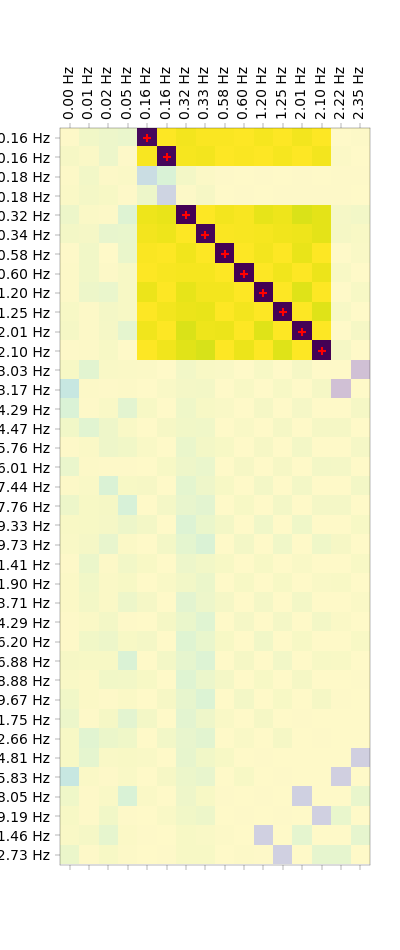

In [23]:
f_a, d_a, phi_a = f_model, d_model, phi_noddir

# f_b, d_b, phi_b = f_sc, d_sc, phi_sc
# f_b, d_b, phi_b = f_cf, d_cf, phi_cf
f_b, d_b, phi_b = f_sd, d_sd, phi_sd
# f_b, d_b, phi_b = acqui.modal_frequencies_samp[:], acqui.modal_damping_samp[:], acqui.mode_shapes_samp[:,:]

# clean up nan-modes from identification
mode_selector = ~np.isnan(f_b)
f_b = f_b[mode_selector]
d_b = d_b[mode_selector]
phi_b = phi_b[:, mode_selector]

# append all nan row to mode shapes to account for missing nodes
phi_b_ = np.concatenate([phi_b, np.full((1,phi_b.shape[1]), np.nan)],axis=0)

# transform "chan"-format to "(x,) y,z"-format
phi_b_noddir = phi_b_[phi_indexer,:]
phi_a_noddir = phi_a[:,[1,2],:]

# flatten both mode shapes again

phi_a_flat = phi_a_noddir.reshape(-1, phi_a_noddir.shape[-1], order='C')
phi_b_flat = phi_b_noddir.reshape(-1, phi_b_noddir.shape[-1], order='C')

# remove all nan-rows (missing nodes from acquisition)
node_selector = ~np.all(np.isnan(phi_b_flat), axis=1)

compare_modes(f_a, d_a, phi_a_flat[node_selector,:],f_b, d_b, phi_b_flat[node_selector,:])

pass

## Compare sets of modal parameters

INFO:pyOMA.core.PostProcessingTools:Statistics on identification: 
Δf = -0.001± 0.002,
Δd = 136.767± 126.411, 
MAC: mean = 0.963, min= 0.868, 
Number of unmatched modes: "a" 26, "b" 25


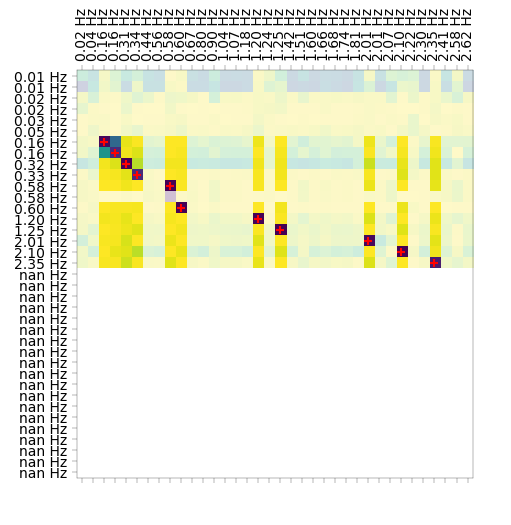

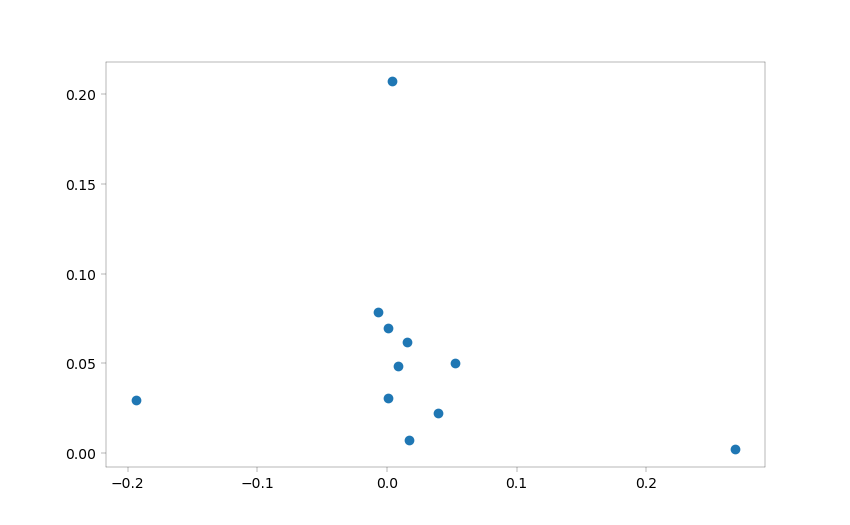

In [26]:
'''
possible sets:
- numerical: acqui.modal_frequencies_samp, ....
- single_order_modal: this_modal_frequencies, ...
- stabilization: stabil_calc.get_selected_modal_values()
- other means: -> assign f_ , d_ , phi_ accordingly
'''

# numerical results
# f_a, d_a, phi_a = acqui.modal_frequencies_samp[:], acqui.modal_damping_samp[:], acqui.mode_shapes_samp[:,:]

# others (mapping results)
f_a, d_a, phi_a, mc_a = f_sc, d_sc, phi_sc, mc_sc
# f_a, d_a, phi_a, mc_a = f_cf, d_cf, phi_cf, np.abs(mc_cf)
# f_a, d_a, phi_a, mc_a = f_sd, d_sd, phi_sd, mc_sd

# numerical results
# f_b, d_b, phi_b = acqui_c.modal_frequencies_samp, acqui_c.modal_damping_samp, acqui_c.mode_shapes_samp

# single_order_modal
# f_b, d_b, phi_b = this_modal_frequencies, this_modal_damping, this_mode_shapes

# stabilization
# f_b, d_b, phi_b = stabil_calc.get_selected_modal_values()[:3]

# others (mapping results)
# f_b, d_b, phi_b, mc_b = f_sc, d_sc, phi_sc, mc_sc
f_b, d_b, phi_b, mc_b = f_cf, d_cf, phi_cf, np.abs(mc_cf)
# f_b, d_b, phi_b, mc_b = f_sd, d_sd, phi_sd, mc_sd
inds_a, inds_b, unp_a, unp_b = compare_modes(f_a, d_a, phi_a, f_b, d_b, phi_b)


plt.figure()
plt.scatter(mc_a[inds_a], mc_b[inds_b])


## Uncertainty Propagation

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=3)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 4000 # increase to accomodate rejection sampling
use_dm = True


In [4]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    
    
    '''
    How to enforce the restrictions?
    - duration is between 10 and 120 minutes, that means block duration is even less (14.6 seconds for 41 blocks)
    - period of f_0 is 6.4 seconds -> tau_max must not be greater than block duration -> just 2.5 cycles of f_0
    - that means, we would be restricted to non-realistic values of tau_max
    - the number of blocks could be lowered, but that does not solve the problem
    - multiple options:
        - model correlation between variables, which is difficult in terms of the mathematical basis of qmc sampling (but would be preferred)
        - manually set samples to bounds (either after sampling (preferred to get consistent results in later uq stages) or in the mapping), again this violates qmc theory
        - (luckily, the correlations are between epistemic primary variables only)
        - we must find a variable that decouples tau_max and duration, something like setting tau_max a percentage of duration, which does not make sense in terms of uq
        - we can also sample tau_max as a percentage of block_duration and then backwards construct M from it (kind of cheating)

    '''
    
    # Rejection sampling https://doi.org/10.1515/mcma-2016-0104
    n_blocks = 41

    f_s = 70 / poly_uq.inp_samp_prim['decimation_factor']
    order = np.copy(poly_uq.inp_samp_prim['model_order'])


    duration = poly_uq.inp_samp_prim['duration']
    block_duration = duration/n_blocks

    if False:
        tau_max = np.copy(poly_uq.inp_samp_prim['tau_max'])
        m_lags = (tau_max * f_s).astype(int)
    else:
        m_lags = np.copy(poly_uq.inp_samp_prim['m_lags'])
        tau_max = m_lags / f_s

    supp_tau_max = poly_uq.var_supp['tau_max']
    supp_m_lags = poly_uq.var_supp['m_lags']

    N = duration * f_s

    selector1 = block_duration >= tau_max
    selector2 = order + 2 <= m_lags

    selector3a = m_lags < supp_m_lags[1]
    selector3b = m_lags > supp_m_lags[0]
    selector3 = selector3a & selector3b

    selector4a = tau_max < supp_tau_max[1]
    selector4b = tau_max > supp_tau_max[0]
    selector4 = selector4a & selector4b

    selector = selector1 & selector2 & selector3  & selector4
    selector[np.cumsum(selector)>1000] = False
    if not np.sum(selector)>=1000: raise RuntimeError("Not enough samples fulfill the rejectance-aceptance criteria. Consider generating more samples.")

    poly_uq.inp_samp_prim['tau_max'] = tau_max
    poly_uq.inp_samp_prim['m_lags'] = m_lags

    poly_uq.inp_samp_prim = poly_uq.inp_samp_prim[selector]
    poly_uq.inp_suppl_ale = poly_uq.inp_suppl_ale[selector]
    poly_uq.inp_suppl_epi = poly_uq.inp_suppl_epi[selector]
    
    poly_uq.N_mcs_epi = 1000
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    '''
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name].array
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name].array
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        # pass
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name].array
    
    for df in [poly_uq.inp_suppl_epi, poly_uq.inp_suppl_ale, poly_uq.inp_samp_prim]:
        for var in df:
            print(np.any(np.isnan(df[var].array)), df[var].shape)
    
    # check, that samples are indeed the same
    if False:
        for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_samp_prim[var_name], poly_uq.inp_samp_prim[var_name])
            plt.title(var_name)
        for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
            plt.title(var_name)
        for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
            plt.title(var_name)
                                                      
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')

else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/polyuq_samp.npz


In [5]:
if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, #kind='hist', 
                 # vars=['decimation_factor','model_order','duration','tau_max','m_lags',]
                )
    plt.gcf().set_size_inches((17,17))

In [6]:
if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None

In [ ]:
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')
todo = True

while todo:    
    modules = ['pyOMA.core.Helpers','pyOMA.core.PreProcessingTools','pyOMA.core.SSICovRef','pyOMA.core.SSIData','pyOMA.core.PLSCF','model.mechanical','model.acquisition']
    for module in modules:
        logger_ = logging.getLogger(module)
        logger_.setLevel(logging.WARNING)


    todo = dm_grid.evaluate_samples(stage2n3mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 'snr_db':(),
                                   'f_sc':('mode',), 'd_sc':('mode',), 'phi_sc':('chan','mode',), 'mc_sc':('mode',), \
                                   'f_cf':('mode',), 'd_cf':('mode',), 'phi_cf':('chan','mode',), 'mc_cf':('mode',), \
                                   'f_sd':('mode',), 'd_sd':('mode',), 'phi_sd':('chan','mode',), 'mc_sd':('mode',), \
                                   'phi_indexer':('node','dir')}, 
                         default_len={'node':203, 'dir':2, 'mode':200, 'chan':25}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=4000, chunks_save=100, scramble_evaluation=True,
                                   remote_kwargs={'num_cpus':10, 'memory':40 * 1024 * 1024 * 1024, 'max_retries':0})

INFO:uncertainty.data_manager:Finished 100 samples in 220.20 s (async. save time: 112.96 s). Remaining 500 samples.
INFO:uncertainty.data_manager:Finished 100, failed 0 samples in 227.60 s
(dm_oma_a pid=42493, ip=141.24.193.131) WARNING:pyOMA.core.SSIData:Block '0' is in the validation dataset, but only has 211 startup-samples (recommended/chosen: 253) from any previous block for the Kalman Filter. Expect a degraded performance.
INFO:uncertainty.data_manager:Finished 100 samples in 227.60 s (async. save time: 111.09 s). Remaining 400 samples.
(dm_oma_a pid=42492, ip=141.24.193.131) WARNING:pyOMA.core.SSIData:Block '0' is in the validation dataset, but only has 444 startup-samples (recommended/chosen: 466) from any previous block for the Kalman Filter. Expect a degraded performance.
INFO:uncertainty.data_manager:Finished 100, failed 0 samples in 202.23 s
INFO:uncertainty.data_manager:Finished 100 samples in 202.23 s (async. save time: 113.03 s). Remaining 300 samples.
(dm_oma_a pid=4248

(raylet, ip=141.24.193.167) [2024-12-02 15:58:43,992 E 63362 63362] (raylet) node_manager.cc:3097: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: cd61f11a231a498fa806b916ba6088df8ac392fbc977ded4b8512598, IP: 141.24.193.167) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 141.24.193.167`
(raylet, ip=141.24.193.167) 
(raylet, ip=141.24.193.167) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [12]:
ray.shutdown()

### Convert db datatypes

In [12]:
import xarray as xr
dbfile = dm_grid.dbfile_out
dbpath = os.path.join(dm_grid.result_dir, dbfile)
ds = xr.open_dataset(dbpath, engine='h5netcdf')

In [13]:
# ds.bits_effective.astype('float32')
names = ['bits_effective', 'snr_db_est', 'snr_db', 'f_sc', 'd_sc', 'mc_sc', 'f_cf', 'd_cf', 'f_sd', 'd_sd', 'mc_sd'] #float64 -> float32
for name in names:
    
    print(name, ds[name].dtype)
    
    ds[name] = ds[name].astype('float32')
ds['mc_cf'] = np.abs(ds['mc_cf']).astype('float32')
names = ['phi_sc','phi_cf', 'phi_sd'] # 'complex128 -> 'complex64'

for name in names:
    print(name, ds[name].dtype)
    ds[name] = ds[name].astype('complex64')

ds['phi_indexer'] = ds['phi_indexer'].astype('uint8')

bits_effective float64
snr_db_est float64
snr_db float64
f_sc float64
d_sc float64
mc_sc float64
f_cf float64
d_cf float64
f_sd float64
d_sd float64
mc_sd float64
phi_sc complex128
phi_cf complex128
phi_sd complex128


In [33]:
ds.close()
tempfile = dbpath + '.tmp'
ds.to_netcdf(tempfile, engine='h5netcdf', invalid_netcdf=True)

# Continue


Further test mapping parameters noise etc for any unwanted/unrealistic effects on the identification
 - verification manually or automatic
   - automatic (see UQ_Acqui.ipynb): 
     - MAC might have a problem with rotated modeshapes
     - available for inclusion in mapping and final verification
     - also modeshape order and major/minor direction can be marked for each identified mode to validate any output-only method for mode clustering
   - mode-pairing should be done post-(uq)-sampling

    
check modeshape rotation with a different example (where alpha is odd)     
then just choose a different example and see, if everything works as expected


- [x] make it run
- [x] test saving and loading at every stage
- [x] manually validate output (modeshape plot)
- [x] get bounds of every parameter
- [x] run for different samples
- [x] change decimation factor in acqui_mech
- [x] check mc
- [x] estimate CPU time, memory and storage requirements
    - [x] optimize, reduce, etc.    
- [?] run full factorial over bounds (stage3)
- [x] verify indexer with model mode shapes
- [x] reduce output size: phi_indexer: unit8, modeshapes: complex64, others to float32
    - [x] change mapping (also change mc_cf to complex magnitude -> float32)
    - [x] convert output db
- [x] find out why ray is failing frequently